In [1]:
import numpy as np
import os
from sklearn import svm
from sklearn import metrics
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy import stats, linalg
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
def conv_r2z(r):
    with np.errstate(invalid='ignore', divide='ignore'):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
def conv_z2r(z):
    with np.errstate(invalid='ignore', divide='ignore'):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
%matplotlib inline

In [2]:
## ------------------ select dataset ------------------ ##
dataset =  'paranoia'
thres = 0.01 #feature selection: correlation with behavior (one-sample t-test, p < thres)
nR = 30
path = ''

nsubj = 30
wsize = 50
nT = 10113

print('Within-dataset prediction')
#print('  dataset = '+str(dataset))
print('  nsubj   = '+str(nsubj))
print('  nregion = '+str(nR))
print('  thres   = '+str(thres))
print('  wsize   = '+str(wsize))

## ------------------ select wsize option ------------------ ##
#wsize = wsize[1]
print('  selected wsize   = '+str(wsize))

Within-dataset prediction
  nsubj   = 30
  nregion = 30
  thres   = 0.01
  wsize   = 50
  selected wsize   = 50


In [13]:
engagement ='load the Sliding_Engagement.mat'
engagement.shape

(2513,)

(2513,)


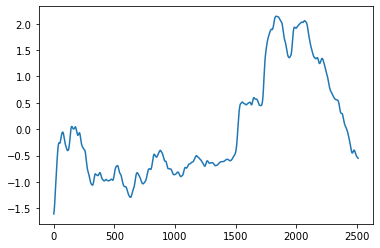

In [14]:
#Load Behav Data
engagement ='load the Sliding_Engagement.mat'
engagement = scipy.stats.zscore(engagement)
plt.plot(engagement)
#plt.title(dataset+': sliding-applied group-average engagement')
print(engagement.shape)

In [15]:
import mat73


(30, 435, 2513)


Text(0.5, 1.0, 'sample FC timecourse')

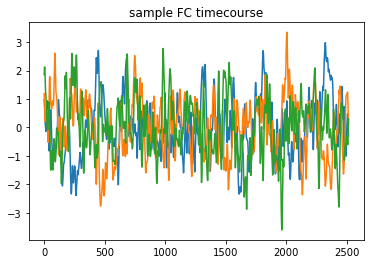

In [16]:
#Load Fc data
dynFeat = 'load the connectivity matrix here'
#dynFeat = scipy.io.loadmat('C:\PhD\Marketing Study\Codes\VIDEO_MEMORY\RESULTS\FEATURES\Whole_video\SlidingFC\dynFeat15.mat')['dynFeat']
dynFeat = scipy.stats.zscore(dynFeat,2,nan_policy='omit') # zscore per feature
print(dynFeat.shape)

plt.plot(dynFeat[0,100,:])
plt.plot(dynFeat[10,100,:])
plt.plot(dynFeat[10,400,:])
plt.title('sample FC timecourse')

In [17]:
def losocv(fmri, behavior, nsubj, rvals):
    output_acc, output_eval, output_pos_feat, output_neg_feat = [], [], np.zeros((nsubj, nR, nR)), np.zeros((nsubj, nR, nR))
    for test_sub in range(nsubj):

        # separate train-test subject
        test_fmri = fmri[test_sub,:,:]
        train_fmri = np.delete(fmri,test_sub,0)

        # every training participants' data are concatenated
        # fed as independent instances to the model
        train_feature = np.transpose(train_fmri,(1,0,2))
        train_feature = np.reshape(train_feature,(train_feature.shape[0],train_feature.shape[1]*train_feature.shape[2]))
        train_behavior = []
        for sub in range(nsubj-1):
            train_behavior.append(behavior)
        train_behavior = np.asarray(train_behavior)
        train_behavior = np.reshape(train_behavior,(train_behavior.shape[0]*train_behavior.shape[1]))

        # features: correlation with behavior
        train_subj_corrmat = np.delete(rvals,test_sub,0)

        # feature selection
        pos_feat, neg_feat, all_feat, nanval = [], [], [], 0
        idx = -1
        for feat in range(int(nR*(nR-1)/2)):
            idx=idx+1
            if np.any(np.isnan(train_subj_corrmat[:,feat])):
                nanval = nanval+1
                pass
            else:
                [tval,pval] = scipy.stats.ttest_1samp(train_subj_corrmat[:,feat],0)
                if pval < thres:
                    if np.average(train_subj_corrmat[:,feat])>0:
                        all_feat.append(idx)
                        pos_feat.append(idx)
                    elif np.average(train_subj_corrmat[:,feat])<0:
                        all_feat.append(idx)
                        neg_feat.append(idx)
        pos_feat, neg_feat, all_feat = np.asarray(pos_feat), np.asarray(neg_feat), np.asarray(all_feat)

        # summarize feature matrix
        idx = -1
        for i1 in range(nR-1):
            for i2 in range(i1+1,nR):
                idx = idx+1
                if idx in pos_feat:
                    output_pos_feat[test_sub,i1,i2]=1
                    output_pos_feat[test_sub,i2,i1]=1
                if idx in neg_feat:
                    output_neg_feat[test_sub,i1,i2]=1
                    output_neg_feat[test_sub,i2,i1]=1

        train_selected_feat = train_feature[all_feat,:]
        test_selected_feat = test_fmri[all_feat, :]
        test_behavior = behavior

        # if any of the TRs are removed
        rmtr_train = []
        for tm in range(train_selected_feat.shape[1]):
            if np.all(np.isnan(train_selected_feat[:,tm])):
                rmtr_train.append(tm)
        rmtr_train = np.asarray(rmtr_train)
        if len(rmtr_train)>0:
            train_selected_feat = np.delete(train_selected_feat,rmtr_train,1)
            train_behavior = np.delete(train_behavior,rmtr_train,0)

        rmtr_test = []
        for tm in range(test_selected_feat.shape[1]):
            if np.all(np.isnan(test_selected_feat[:, tm])):
                rmtr_test.append(tm)
        rmtr_test = np.asarray(rmtr_test)
        if len(rmtr_test) > 0:
            test_selected_feat = np.delete(test_selected_feat, rmtr_test, 1)
            test_behavior = np.delete(test_behavior,rmtr_test,0)

        # Support vector regression with non-linear kernel
        clf = []
        clf = svm.SVR(kernel='rbf',max_iter=1000, gamma='auto')
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            clf.fit(train_selected_feat.T, train_behavior)
        predicted = clf.predict(test_selected_feat.T)
        output_acc.append(predicted)

        # evaluate
        pearsonr = scipy.stats.pearsonr(test_behavior, predicted)
        mse = metrics.mean_squared_error(test_behavior, predicted)
        rsq = metrics.r2_score(test_behavior, predicted)
        output_eval.append([pearsonr[0], mse, rsq])
        print('  subj '+str(test_sub+1)+' / '+str(nsubj)+': #feat '+str(len(all_feat))+', pearson r='+str(np.round(pearsonr[0],3)),', mse='+str(np.round(mse,3))+', rsq='+str(np.round(rsq,3)))
        print('               (train) ft '+str(train_selected_feat.shape[1])+', beh '+str(train_behavior.shape[0])+
              ', (test) ft '+str(test_selected_feat.shape[1])+', beh '+str(test_behavior.shape[0]))

    output_acc, output_eval, output_pos_feat, output_neg_feat = np.asarray(output_acc), np.asarray(output_eval), np.asarray(output_pos_feat), np.asarray(output_neg_feat)
    return output_acc, output_eval, output_pos_feat, output_neg_feat
# output_acc contains predicted values for each subject>> 30*10113
# first column of output_eval contains correlation of predicted behavior with test behavior>> 1*30

In [18]:
# calculate correlation with behavior (engagement) for all FC features
allsubj_corrmat = np.zeros((nsubj,int(nR*(nR-1)/2)))
# for Sherlock, some participants' MNI-aligned images contain zero voxel (node 24 and 82)
for sub in range(nsubj):
    if dataset=='sherlock' and sub == 4:
        for feat in range(int(nR*(nR-1)/2)):
            if np.any(np.isnan(dynFeat[sub,feat,:nT-wsize-51]))==True:
                rval=np.nan
            else:
                [rval,pval] = scipy.stats.pearsonr(dynFeat[sub,feat,:nT-wsize-51], engagement[:nT-wsize-51])
            allsubj_corrmat[sub,feat] = rval
    else:
        for feat in range(int(nR*(nR-1)/2)):
            if np.any(np.isnan(dynFeat[sub,feat,:]))==True:
                rval=np.nan
            else:
                [rval,pval] = scipy.stats.pearsonr(dynFeat[sub,feat,:], engagement)
            allsubj_corrmat[sub,feat] = rval
print(allsubj_corrmat.shape)

(30, 435)


In [8]:
[output_acc, output_eval, output_pos_feat, output_neg_feat] = losocv(dynFeat, engagement, nsubj, allsubj_corrmat)

  subj 1 / 30: #feat 6, pearson r=-0.004 , mse=1.056, rsq=-0.056
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 2 / 30: #feat 7, pearson r=0.008 , mse=1.027, rsq=-0.027
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 3 / 30: #feat 7, pearson r=0.055 , mse=1.04, rsq=-0.04
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 4 / 30: #feat 7, pearson r=0.041 , mse=1.046, rsq=-0.046
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 5 / 30: #feat 5, pearson r=0.017 , mse=1.057, rsq=-0.057
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 6 / 30: #feat 6, pearson r=0.014 , mse=1.072, rsq=-0.072
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 7 / 30: #feat 6, pearson r=0.066 , mse=1.02, rsq=-0.02
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 8 / 30: #feat 4, pearson r=-0.052 , m

In [9]:
savepath=''
result = {'acc':output_acc, 'eval':output_eval, 'pos_feat':output_pos_feat, 'neg_feat':output_neg_feat}
if os.path.exists(savepath)==0:
    os.makedirs(savepath)
scipy.io.savemat(savepath+'/within_engagement.mat',result)

In [19]:
#####added by me:test on one subject
test_sub = 1;
fmri = dynFeat 
behavior = engagement 
output_acc, output_eval, output_pos_feat, output_neg_feat = [], [], np.zeros((nsubj, nR, nR)), np.zeros((nsubj, nR, nR))

test_fmri = fmri[test_sub,:,:]
train_fmri = np.delete(fmri,test_sub,0)

   # every training participants' data are concatenated
        # fed as independent instances to the model
train_feature = np.transpose(train_fmri,(1,0,2))
train_feature = np.reshape(train_feature,(train_feature.shape[0],train_feature.shape[1]*train_feature.shape[2]))
train_behavior = []
for sub in range(nsubj-1):
    train_behavior.append(behavior)
train_behavior = np.asarray(train_behavior)
train_behavior = np.reshape(train_behavior,(train_behavior.shape[0]*train_behavior.shape[1]))

# features: correlation with behavior
rvals = allsubj_corrmat
train_subj_corrmat = np.delete(rvals,test_sub,0)

# feature selection
pos_feat, neg_feat, all_feat, nanval = [], [], [], 0
idx = -1
for feat in range(int(nR*(nR-1)/2)):
    idx=idx+1
    if np.any(np.isnan(train_subj_corrmat[:,feat])):
        nanval = nanval+1
        pass
    else:
        [tval,pval] = scipy.stats.ttest_1samp(train_subj_corrmat[:,feat],0)
        if pval < thres:
            if np.average(train_subj_corrmat[:,feat])>0:
                all_feat.append(idx)
                pos_feat.append(idx)
            elif np.average(train_subj_corrmat[:,feat])<0:
                all_feat.append(idx)
                neg_feat.append(idx)
pos_feat, neg_feat, all_feat = np.asarray(pos_feat), np.asarray(neg_feat), np.asarray(all_feat)

# summarize feature matrix
idx = -1
for i1 in range(nR-1):
    for i2 in range(i1+1,nR):
        idx = idx+1
        if idx in pos_feat:
            output_pos_feat[test_sub,i1,i2]=1
            output_pos_feat[test_sub,i2,i1]=1
        if idx in neg_feat:
            output_neg_feat[test_sub,i1,i2]=1
            output_neg_feat[test_sub,i2,i1]=1

train_selected_feat = train_feature[all_feat, :] ###########the size of the train is not correct
test_selected_feat = test_fmri[all_feat, :]
test_behavior = behavior

# if any of the TRs are removed
rmtr_train = []
for tm in range(train_selected_feat.shape[1]):
    if np.all(np.isnan(train_selected_feat[:,tm])):
        rmtr_train.append(tm)
rmtr_train = np.asarray(rmtr_train)
if len(rmtr_train)>0:
    train_selected_feat = np.delete(train_selected_feat,rmtr_train,1)
    train_behavior = np.delete(train_behavior,rmtr_train,0)

rmtr_test = []
for tm in range(test_selected_feat.shape[1]):
    if np.all(np.isnan(test_selected_feat[:, tm])):
        rmtr_test.append(tm)
rmtr_test = np.asarray(rmtr_test)
if len(rmtr_test) > 0:
    test_selected_feat = np.delete(test_selected_feat, rmtr_test, 1)
    test_behavior = np.delete(test_behavior,rmtr_test,0)
    
# Support vector regression with non-linear kernel
clf = []
clf = svm.SVR(kernel='rbf',max_iter=1000, gamma='auto')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf.fit(train_selected_feat.T, train_behavior)
predicted = clf.predict(test_selected_feat.T)
output_acc.append(predicted)

# evaluate
pearsonr = scipy.stats.pearsonr(test_behavior, predicted)
mse = metrics.mean_squared_error(test_behavior, predicted)
rsq = metrics.r2_score(test_behavior, predicted)
output_eval.append([pearsonr[0], mse, rsq])
print('  subj '+str(test_sub+1)+' / '+str(nsubj)+': #feat '+str(len(all_feat))+', pearson r='+str(np.round(pearsonr[0],3)),', mse='+str(np.round(mse,3))+', rsq='+str(np.round(rsq,3)))
print('               (train) ft '+str(train_selected_feat.shape[1])+', beh '+str(train_behavior.shape[0])+
      ', (test) ft '+str(test_selected_feat.shape[1])+', beh '+str(test_behavior.shape[0]))

  subj 2 / 30: #feat 6, pearson r=0.108 , mse=1.101, rsq=-0.101
               (train) ft 72877, beh 72877, (test) ft 2513, beh 2513


In [20]:
all_feat

array([ 79, 139, 237, 254, 272, 376])

Prediction result (mean of cross-validations): paranoia
 pearson r = 0.009
 MSE       = 1.055
 r-squared = -0.055


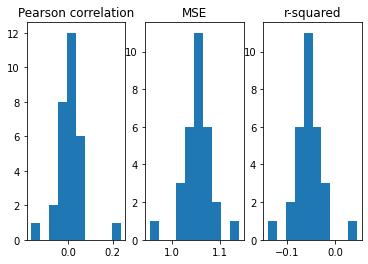

In [10]:
##Check cross-validation prediction accuracy
fig, axs = plt.subplots(1,3)
axs[0].hist(output_eval[:,0])
axs[0].set_title('Pearson correlation')
axs[1].hist(output_eval[:,1])
axs[1].set_title('MSE')
axs[2].hist(output_eval[:,2])
axs[2].set_title('r-squared')

print('Prediction result (mean of cross-validations): '+dataset)
print(' pearson r = '+str(np.round(conv_z2r(np.mean(conv_r2z(output_eval[:,0]))),3)))
print(' MSE       = '+str(np.round(np.mean(output_eval[:,1]),3)))
print(' r-squared = '+str(np.round(np.mean(output_eval[:,2]),3)))

phase randomized engagement rating: shape (10113, 10)


Text(0.5, 1.0, 'phase randomized engagement: sample =10')

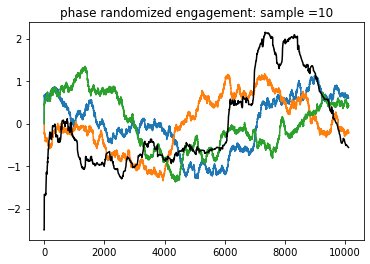

In [11]:
niter = 10
# permutation takes huge amount of time, so let's try with small number

engagement_surr ='load sliding_surr_Engagement.mat here'
print('phase randomized engagement rating: shape '+str(engagement_surr.shape))

# plot sample phase-randomized engagement time course
plt.plot(engagement_surr[:,:3])
plt.plot(engagement,color='black')
plt.title('phase randomized engagement: sample ='+str(niter))

In [12]:
if not os.path.exists(savepath+'/within_engagement_null'):
    os.makedirs(savepath+'/within_engagement_null')

print('Null prediction results: iter = '+str(niter))
surr_pearsonr, surr_mse, surr_rsq = [], [], []
for iter in range(niter):
    print('null '+str(iter+1)+' / '+str(niter))
    # calculate correlation with behavior (engagement) for all FC features
    surr_corrmat = np.zeros((nsubj,int(nR*(nR-1)/2)))
    for sub in range(nsubj):
        if dataset=='sherlock' and sub==4:
            for feat in range(int(nR*(nR-1)/2)):
                if np.any(np.isnan(dynFeat[sub,feat,:nT-wsize-51])) == True:
                    rval=np.nan
                else:
                    [rval, pval] = scipy.stats.pearsonr(dynFeat[sub,feat,:nT-wsize-51],engagement_surr[:nT-wsize-51,iter])
                surr_corrmat[sub,feat] = rval
        else:
            for feat in range(int(nR*(nR-1)/2)):
                if np.any(np.isnan(dynFeat[sub,feat,:]))==True:
                    rval=np.nan
                else:
                    [rval,pval] = scipy.stats.pearsonr(dynFeat[sub,feat,:], engagement_surr[:,iter])
                surr_corrmat[sub,feat] = rval
    
    [surr_acc, surr_eval, surr_pos_feat, surr_neg_feat] = losocv(dynFeat, engagement_surr[:,iter], nsubj, surr_corrmat)
    surr_pearsonr.append(surr_eval[:,0])
    surr_mse.append(surr_eval[:,1])
    surr_rsq.append(surr_eval[:,2])
    print('null '+str(iter+1)+' / '+str(niter)+
          ' : pearson r = '+str(np.round(conv_z2r(np.mean(conv_r2z(surr_eval[:,0]))),3))+
          ', mse = '+str(np.round(np.average(surr_eval[:,1]),3))+
          ', rsq = '+str(np.round(np.average(surr_eval[:,2]),3)))
    
    result = {'acc':surr_acc, 'eval':surr_eval, 'pos_feat':surr_pos_feat, 'neg_feat':surr_neg_feat}
    scipy.io.savemat(savepath+'/within_engagement_null/null'+str(iter+1)+'.mat',result)

surr_pearsonr, surr_mse, surr_rsq = np.asarray(surr_pearsonr), np.asarray(surr_mse), np.asarray(surr_rsq)

Null prediction results: iter = 10
null 1 / 10
  subj 1 / 30: #feat 10, pearson r=0.071 , mse=0.445, rsq=-0.078
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 2 / 30: #feat 10, pearson r=-0.002 , mse=0.446, rsq=-0.08
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 3 / 30: #feat 8, pearson r=-0.002 , mse=0.455, rsq=-0.102
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 4 / 30: #feat 10, pearson r=0.059 , mse=0.447, rsq=-0.083
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 5 / 30: #feat 9, pearson r=0.005 , mse=0.476, rsq=-0.153
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 6 / 30: #feat 8, pearson r=0.054 , mse=0.438, rsq=-0.061
               (train) ft 293277, beh 293277, (test) ft 10113, beh 10113
  subj 7 / 30: #feat 11, pearson r=-0.009 , mse=0.444, rsq=-0.075
               (train) ft 293277, beh 293277, (test) ft 10113

In [13]:
def onetail_p(real, null):
    p = (1 + np.sum(null>=real)) / (1+len(null))
    print(str(np.sum(null>=real))+' among '+str(len(null))+' null has higher r value than actual prediction')
    return p

In [14]:
p = onetail_p(conv_z2r(np.mean(conv_r2z(output_eval[:,0]))), conv_z2r(np.average(conv_r2z(surr_pearsonr),1)))
print('p = '+str(np.round(p,3)))

4 among 10 null has higher r value than actual prediction
p = 0.455


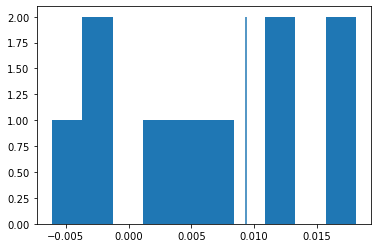

In [15]:
plt.hist(conv_z2r(np.average(conv_r2z(surr_pearsonr),1)))
plt.vlines(conv_z2r(np.mean(conv_r2z(output_eval[:,0]))),0,2)